<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Deploy a model in the cloud - P8</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Notebook - Proof of Concept |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries & static variables</h2>
</div>

In [56]:
## General
import numpy as np
from io import BytesIO
from PIL import Image

## To use S3 files
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import input_file_name, col, split
import sagemaker_pyspark

## To use S3 files
import botocore.session
import boto3

In [2]:
BUCKET = "oc-p8-bucket"
SUBFOLDER = "test/images/"
DUMMY_FILE = "SampleCSVFile_556kb.csv"

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1 loading the sagemaker jars </h3>
</div>

In [3]:
conf = (SparkConf()
        .set("spark.driver.extraClassPath", ":".join(sagemaker_pyspark.classpath_jars())))
SparkContext(conf=conf)

<SparkContext master=local[*] appName=pyspark-shell>

<div class="alert alert-block alert-info">
    <p>Here, we can notice which is the Spark's version (2.4 LTS).<br>
        It is not the latest version but, as of today (2022/03), it is still a tested version with support.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Testing connection to S3</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to print the name of the first 5 elements in the S3.</p>
</div>

In [4]:
conn = boto3.client("s3")

In [5]:
contents = conn.list_objects(Bucket=BUCKET)["Contents"]
for k in list(contents)[:5]:
    print(k["Key"])

SampleCSVFile_556kb.csv
test/
test/images/
test/images/Apricot/0_100.jpg
test/images/Apricot/123_100.jpg


<div class="alert alert-block alert-info">
    <p>Now, we are going to test whether we can read an image from S3.</p>
</div>

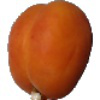

In [6]:
test_img = Image.open(
            BytesIO(
                conn.get_object(
                    Bucket=BUCKET, 
                    Key=list(contents)[5]["Key"])["Body"].read()
            )
        )

test_img

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Spark session</h2>
</div>

In [7]:
session = botocore.session.get_session()
credentials = session.get_credentials()

In [8]:
spark = (
    SparkSession
    .builder
    .config(conf=conf) \
    .config("fs.s3a.access.key", credentials.access_key)
    .config("fs.s3a.secret.key", credentials.secret_key)
    .appName("P8-FRUITS")
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
    .getOrCreate()
)

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1 Testing connection to S3 with Spark</h3>
</div>

In [9]:
data_location = "s3a://{}/{}".format(BUCKET, DUMMY_FILE)

In [10]:
df_dummy = spark.read.csv(data_location, header="True", inferSchema=True)
df_dummy = df_dummy.drop("1")

In [11]:
df_dummy.limit(5).toPandas()

,"Eldon Base for stackable storage shelf, platinum",Muhammed MacIntyre,3,-213.25,38.94,35,Nunavut,Storage & Organization,0.8
0,"""1.7 Cubic Foot Compact """"Cube"""" Office Refrig...",Barry French,293,457.81,208.16,68.02,Nunavut,Appliances,0.58
1,"Cardinal Slant-D� Ring Binder, Heavy Gauge Vinyl",Barry French,293,46.71,8.69,2.99,Nunavut,Binders and Binder Accessories,0.39
2,R380,Clay Rozendal,483,1198.97,195.99,3.99,Nunavut,Telephones and Communication,0.58
3,Holmes HEPA Air Purifier,Carlos Soltero,515,30.94,21.78,5.94,Nunavut,Appliances,0.5
4,G.E. Longer-Life Indoor Recessed Floodlight Bulbs,Carlos Soltero,515,4.43,6.64,4.95,Nunavut,Office Furnishings,0.37


In [12]:
df_dummy.printSchema()

root
 |-- Eldon Base for stackable storage shelf, platinum: string (nullable = true)
 |-- Muhammed MacIntyre: string (nullable = true)
 |-- 3: string (nullable = true)
 |-- -213.25: string (nullable = true)
 |-- 38.94: string (nullable = true)
 |-- 35: string (nullable = true)
 |-- Nunavut: string (nullable = true)
 |-- Storage & Organization: string (nullable = true)
 |-- 0.8: string (nullable = true)



<div class="alert alert-block alert-success">
    <p>Great!, we can access to S3 from ours Notebook through Spark / Pyspark</p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2 Testing reading and image from S3 through Spark</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, let's try to read an image from the bucket</p>
</div>

In [19]:
image = spark.read.format("image").load("s3a://{}/{}".format(BUCKET, list(contents)[5]["Key"]))

In [20]:
image.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [21]:
image.show()

+--------------------+
|               image|
+--------------------+
|[s3a://oc-p8-buck...|
+--------------------+



In [32]:
img = image.first()

In [33]:
img = np.array(img.asDict()["image"]["data"]).reshape(100, 100, 3)[:, :, ::-1]

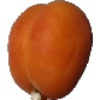

In [34]:
Image.fromarray(img, "RGB")

<div class="alert alert-block alert-success">
    <p>So far, We have access to an image. Let's go to read all images in the bucket.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Reading images with Spark</h2>
</div>

<div class="alert alert-block alert-info">
    <p>To read the images, we will restrict the format only to *.jpg. In addition, we will read all subdirectories in the main directory.</p>
</div>

In [42]:
df_images = spark.read.format("image")\
      .option("pathGlobFilter", "*.jpg")\
      .option("recursiveFileLookup", "true")\
      .load("s3a://{}/{}/*".format(BUCKET, SUBFOLDER))

In [43]:
df_images.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [47]:
df_images.show(5)

+--------------------+
|               image|
+--------------------+
|[s3a://oc-p8-buck...|
|[s3a://oc-p8-buck...|
|[s3a://oc-p8-buck...|
|[s3a://oc-p8-buck...|
|[s3a://oc-p8-buck...|
+--------------------+
only showing top 5 rows



<div class="alert alert-block alert-info">
    <p>Let's get the path and the category of the each image.</p>
</div>

In [61]:
df_images = df_images.withColumn("path", input_file_name())
df_images = df_images.withColumn("category", split(col("path"), "/").getItem(5))
df_images.show(5)

+--------------------+--------------------+----------+
|               image|                path|  category|
+--------------------+--------------------+----------+
|[s3a://oc-p8-buck...|s3a://oc-p8-bucke...| Raspberry|
|[s3a://oc-p8-buck...|s3a://oc-p8-bucke...| Raspberry|
|[s3a://oc-p8-buck...|s3a://oc-p8-bucke...| Raspberry|
|[s3a://oc-p8-buck...|s3a://oc-p8-bucke...| Raspberry|
|[s3a://oc-p8-buck...|s3a://oc-p8-bucke...|Watermelon|
+--------------------+--------------------+----------+
only showing top 5 rows



<div style="background-color: red;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">&gt;&gt;&gt; FLAG &lt;&lt;&lt;</h1>
</div>